Load the data.

In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt


def load_data(filename, dims):
    with gzip.open(filename, "rb") as infile:
        # consume magic number
        infile.read(4)
        # consume dimensions data
        infile.read(4 * len(dims))

        return np.frombuffer(infile.read(np.prod(dims)), dtype=np.uint8).reshape(dims)

# training data
train_images = load_data("data/train-images-idx3-ubyte.gz", [60000, 28, 28])
train_labels = load_data("data/train-labels-idx1-ubyte.gz", [60000])

# testing data
test_images = load_data("data/t10k-images-idx3-ubyte.gz", [10000, 28, 28])
test_labels = load_data("data/t10k-labels-idx1-ubyte.gz", [10000])

Process the data for training and testing.

In [2]:
train_x = train_images.astype(np.float) / 255
train_y = np.zeros((60000, 10))
train_y[np.arange(60000),train_labels] = 1

test_x = test_images.astype(np.float) / 255
test_y = np.zeros((10000, 10))
test_y[np.arange(10000),test_labels] = 1

Create embeddings for the training data.

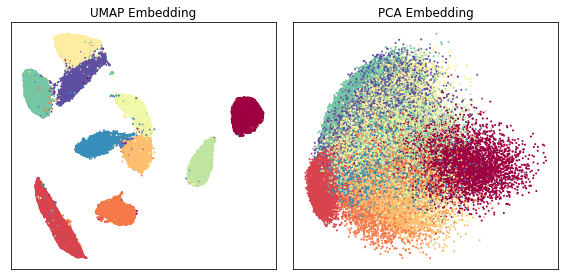

In [3]:
import os
import pickle
from umap import UMAP
from sklearn.decomposition import PCA


def create_embeddings(data, ignore_cache=False):
    umap_dir = "cache/umap.pickle"
    pca_dir = "cache/pca.pickle"

    if not os.path.isfile(umap_dir) or ignore_cache:
        umap_reducer = UMAP(random_state=42).fit(data)
        pickle.dump(umap_reducer, open(umap_dir, "wb"))
    else:
        umap_reducer = pickle.load(open(umap_dir, "rb"))

    if not os.path.isfile(pca_dir) or ignore_cache:
        pca_reducer = PCA(n_components=2, random_state=42).fit(data)
        pickle.dump(pca_reducer, open(pca_dir, "wb"))
    else:
        pca_reducer = pickle.load(open(pca_dir, "rb"))
        
    return umap_reducer, pca_reducer


umap_reducer, pca_reducer = create_embeddings(train_x.reshape(-1, 784), ignore_cache=False)
umap_data = umap_reducer.transform(train_x.reshape(-1, 784))
pca_data = pca_reducer.transform(train_x.reshape(-1, 784))


def plot_embeddings():
    fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(8,4))
    axes[0].scatter(umap_data[:,0], umap_data[:,1], s=1, c=train_labels, cmap='Spectral')
    axes[0].set_title("UMAP Embedding")

    axes[1].scatter(pca_data[:,0], pca_data[:,1], s=1, c=train_labels, cmap='Spectral')
    axes[1].set_title("PCA Embedding")
    plt.setp(axes, xticks=[], yticks=[])
    plt.tight_layout()
    
plot_embeddings()

Train the model with random weights.

Using TensorFlow backend.
W0214 10:31:57.238629 140593226557248 deprecation.py:323] From /home/ryan-desktop/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.3208 - categorical_accuracy: 0.4485 - val_loss: 0.2445 - val_categorical_accuracy: 0.7580
Epoch 2/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.2132 - categorical_accuracy: 0.7979 - val_loss: 0.1842 - val_categorical_accuracy: 0.8354
Epoch 3/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.1628 - categorical_accuracy: 0.8503 - val_loss: 0.1425 - val_categorical_accuracy: 0.8743
Epoch 4/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.1293 - categorical_accuracy: 0.8748 - val_loss: 0.1156 - val_categorical_accuracy: 0.8882
Epoch 5/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.1065 - categorical_accuracy: 0.8925 - val_loss: 0.0978 - val_categorical_accuracy: 0.9000
Epoch 6/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.0915 - categor

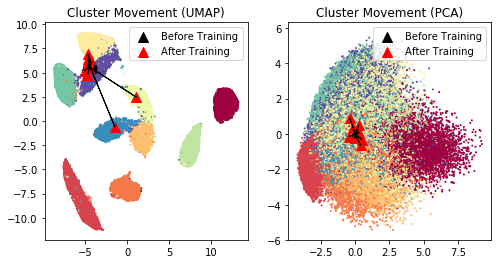

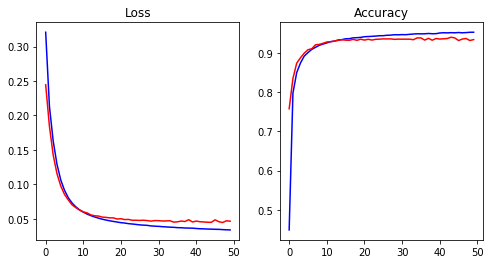

In [4]:
import keras
import keras.layers as layers
import keras.models as models
from model import GaussMembership, normalized_product_fn


def plot_cluster_movement(ax, data, init, current):
    change = current - init
    
    ax.scatter(data[:,0], data[:,1], s=1, c=train_labels, cmap='Spectral')
    s1 = ax.scatter(init[:,0], init[:,1], s=100, c="k", marker="^")
    s2 = ax.scatter(current[:,0], current[:,1], s=100, c="r", marker="^")
    
    for i in range(change.shape[0]):
        ax.arrow(init[i,0], init[i,1], change[i,0], change[i,1])
    ax.legend([s1, s2], ["Before Training", "After Training"])


# create the model
model = keras.Sequential([
    layers.Reshape((784,), input_shape=(28,28)),
    GaussMembership(10),
    layers.Lambda(lambda x: normalized_product_fn(x)),
    layers.Dense(10, activation="sigmoid"),])

# set weights randomly
model.layers[1].set_weights((
    # multiplying the by the mean is a way to ensure that the centers occupy the same subset of the
    # feature space as the input data
    np.random.normal(1., 0.1, size=(10,784)) * np.mean(train_x.reshape(-1, 784), axis=0, keepdims=True),
    np.random.normal(1., 0.1, size=(10,784))))

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[keras.metrics.categorical_accuracy])

init_mu, init_sigma = model.layers[1].get_weights()

# train the model
history = model.fit(
    x=train_x,
    y=train_y,
    batch_size=64,
    epochs=50,
    validation_data=(test_x, test_y),
    verbose=1,
    shuffle=True)

final_mu, final_sigma = model.layers[1].get_weights()

# plot the cluster movement
fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(8,4))
axes[0].set_title("Cluster Movement (UMAP)")
plot_cluster_movement(
    axes[0], umap_data,
    umap_reducer.transform(init_mu), 
    umap_reducer.transform(final_mu))

axes[1].set_title("Cluster Movement (PCA)")
plot_cluster_movement(
    axes[1], pca_data,
    pca_reducer.transform(init_mu), 
    pca_reducer.transform(final_mu))

# plot the loss and accuracy
fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
axes[0].set_title("Loss")
axes[0].plot(history.history["loss"], c="b")
axes[0].plot(history.history["val_loss"], c="r")

axes[1].set_title("Accuracy")
#axes[1].set_ylim((0.8, 1))
axes[1].plot(history.history["categorical_accuracy"], c="b")
axes[1].plot(history.history["val_categorical_accuracy"], c="r")

The clusters still do not seem to occupy logical locations.

We will create images from the mu and sigma parameters to try and figure out why this is.

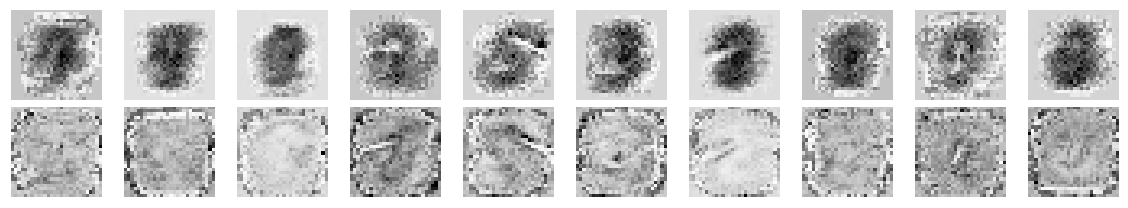

In [5]:
fig, axes = plt.subplots(2, 10, figsize=(16,3))
for i in range(10):
    axes[0][i].imshow(final_mu[i,:].reshape(28, 28), cmap="Greys", interpolation="none")
    axes[1][i].imshow(final_sigma[i,:].reshape(28, 28), cmap="Greys", interpolation="none")

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

The images above offer some insight as to why the centers learned by the network do not make sense. The mu plots (on the top row) show that the the centers learned hardly resemble handwritten digits. 

This means gives some insight to why they appear in weird locations on the 2D embeddings. UMAP learns a 2D manifold close to the data in the original feature space and then uses the manifold to project the data to 2D. Since these centers do not resemble the original data, it is likely that they are not near this manifold and UMAP maps them to locations that are not near the original digits.

I believe something similar is occuring with PCA, where the clusters exist outside of the subset of space where the original data exists meaning PCA cannot meaningfully transform them.

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.4163 - categorical_accuracy: 0.1536 - val_loss: 0.3099 - val_categorical_accuracy: 0.2886
Epoch 2/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.2594 - categorical_accuracy: 0.5189 - val_loss: 0.2258 - val_categorical_accuracy: 0.6185
Epoch 3/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.2052 - categorical_accuracy: 0.6794 - val_loss: 0.1881 - val_categorical_accuracy: 0.7264
Epoch 4/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.1745 - categorical_accuracy: 0.7412 - val_loss: 0.1632 - val_categorical_accuracy: 0.7651
Epoch 5/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.1537 - categorical_accuracy: 0.7720 - val_loss: 0.1454 - val_categorical_accuracy: 0.7927
Epoch 6/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.1388 - categor

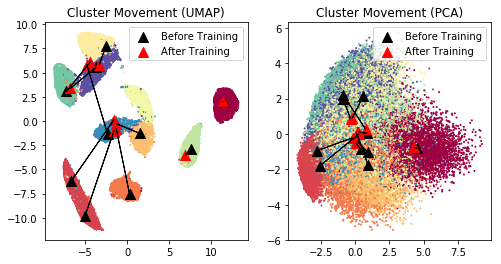

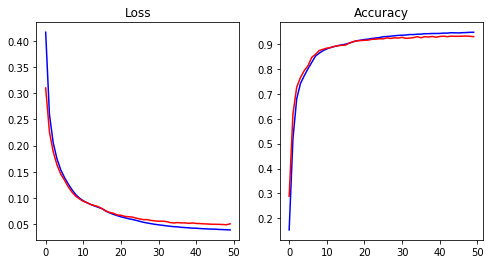

In [6]:
import skfuzzy as skf


# create the model
model = keras.Sequential([
    layers.Reshape((784,), input_shape=(28,28)),
    GaussMembership(10),
    layers.Lambda(lambda x: normalized_product_fn(x)),
    layers.Dense(10, activation="sigmoid"),])

init_mu, memberships, u0, d, jm, p, fpc = skf.cmeans(
    train_x.reshape(-1, 784).T, 10, 1.1, 1e-8, 1000, seed=0)

# set weights with fcm
model.layers[1].set_weights((
    init_mu,
    np.random.normal(1., 0.1, size=(10,784))))

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[keras.metrics.categorical_accuracy])

init_mu, init_sigma = model.layers[1].get_weights()

# train the model
history = model.fit(
    x=train_x,
    y=train_y,
    batch_size=64,
    epochs=50,
    validation_data=(test_x, test_y),
    verbose=1,
    shuffle=True)

final_mu, final_sigma = model.layers[1].get_weights()

# plot the cluster movement
fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(8,4))
axes[0].set_title("Cluster Movement (UMAP)")
plot_cluster_movement(
    axes[0], umap_data,
    umap_reducer.transform(init_mu), 
    umap_reducer.transform(final_mu))

axes[1].set_title("Cluster Movement (PCA)")
plot_cluster_movement(
    axes[1], pca_data,
    pca_reducer.transform(init_mu), 
    pca_reducer.transform(final_mu))

# plot the loss and accuracy
fig, axes = plt.subplots(1, 2, figsize=(8, 4), squeeze=True)
axes[0].set_title("Loss")
axes[0].plot(history.history["loss"], c="b")
axes[0].plot(history.history["val_loss"], c="r")

axes[1].set_title("Accuracy")
#axes[1].set_ylim((0.8, 1))
axes[1].plot(history.history["categorical_accuracy"], c="b")
axes[1].plot(history.history["val_categorical_accuracy"], c="r")

Here, the clusters start in locations that appear correct. However, as the model learns the clusters move away from the seemingly correct locations. I would assume this is because the centers found by FCM are near the UMAP manifold, but move away during training.

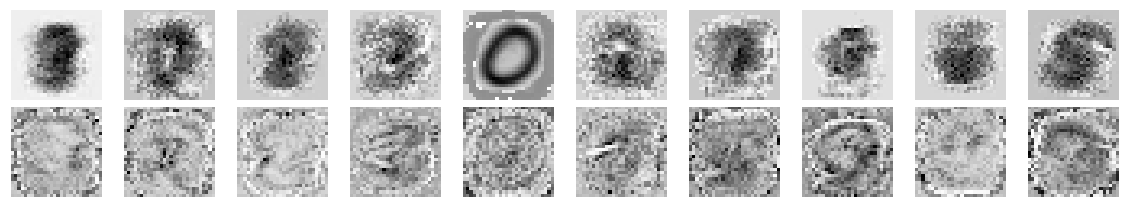

In [7]:
fig, axes = plt.subplots(2, 10, figsize=(16,3))
for i in range(10):
    axes[0][i].imshow(final_mu[i,:].reshape(28, 28), cmap="Greys", interpolation="none")
    axes[1][i].imshow(final_sigma[i,:].reshape(28, 28), cmap="Greys", interpolation="none")

plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0, w_pad=0)

Of all the rules, the only one that resembles a digit is the rule for 0. The rest look random.

This section was suppose to use gradient descent to train the input images to maximize each output. This would let us see what the network thinks is most important for each digit. Unfortunately, it is very inconsistent and rarely converges to the desired result (the network classifies it as something other than what the target was).

In [113]:
# from keras import backend as K


# prediction = 1
# while prediction != 0:
#     image = np.random.normal(0.5, 0.1, size=(1,28,28))
    
#     # train the image to classifier as 0
#     target = np.zeros((1,10))
#     target[:,0] = 1

#     # loss and gradients
#     loss = -K.sum(target * K.log(model.output) + (1 - target) * K.log(1 - model.output))
#     grads = K.gradients(loss, model.inputs)
#     grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-8)

#     iterate = K.function(model.inputs, [loss, grads])

#     for i in range(20):
#         loss_val, grads_val = iterate([image])
#         image -= grads_val.reshape(1,28,28)

I believe the network works by using the membership functions as a measure of similarity between the input vector and the parameter mu, while using sigma as measure of feature importance. The larger the value of sigma, the more the feature can deviate from mu without greatly affecting the firing strength of the rule. With smaller values of sigma, the features must match mu closely in those dimensions. This leads the network to only use small parts of the image to classify the example and is not really easily translated to something human understandable.